# State Schema

We are going to build a deeper understanding of State Schema and its components. 

### Schema

When we define LangGraph `StateGraph`, we use a state schema. 

It provides a communication structure (a way to communicate) between nodes along with types of data (channels) through which information flows.

### TypedDict

It is a dictionary subclass from Python's standard library that allows to specify channels and corresponding value types.

Not that these are type hints. This indicates that the expected input value is of a particular type.

In [19]:
from typing import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: int

# Here, the channels indicated by foo and bar will be updated based on the interaction with the nodes.
# The data type indicated by the channels tells the type of the data that will be sent through the channels.
# The data type of the channels should be consistent with the data type of the TypedDictState.

In [4]:
# For more specific constraints, we can use things like `Literal` type hint
# Here, mood can only be either 'happy' or 'sad'

from typing import Literal
class TypedDictStateWithLiteral(TypedDict):
    foo: str
    bar: int
    mood: Literal['happy', 'sad']

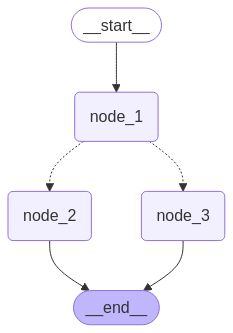

In [32]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"bar": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"bar": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
graph.invoke({"foo": "foo"})
# TypeDict invocation can get away without specifying other keys.

---Node 1---
---Node 2---


{'foo': 'foo is ... ', 'bar': 'happy'}

### Dataclass

Python's dataclass provides another way to define structured data.

It offers a concise syntax for creating classes that are primarily used to store data.

In the return statement for nodes, we still return a dictionary even though our state is a `dataclass`.


In [36]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    bar: int
    mood: Literal['happy', 'sad']

# In dataclass, access the values using the dot operator instead of the key operator
# For example, `state.foo` instead of `state['foo']

# But now we can't invoke our graph with a dictionary, we need to use the dataclass instance
# state = DataClassState(foo='hello', bar=42, mood='happy')
# app.invoke(state)

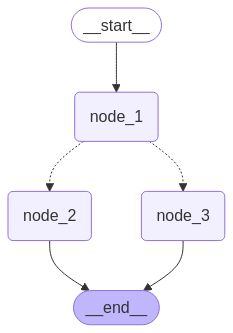

In [37]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
graph.invoke(DataclassState(name="Raj", bar=4, mood='happy'))
# In dataclass invocation, we cannot get away without specifying all the keys.

---Node 1---
---Node 2---


{'name': 'Raj is ... ', 'bar': 'happy', 'mood': 'happy'}

### Pydantic

Pydantic is a powerful data validation and settings management library using Python type annotations.

As mentioned, TypedDict and Dataclasses provide type hints but they don't enforce types at runtime.

This means we can potentially provide invalid values without raising an error!

Pydantic is well-suited for defining state schemas in LangGraph due to its robust validation capabilities.

It runs checks whether data conforms to the specified types and constraints at runtime.

In [8]:
from langchain_core.pydantic_v1 import BaseModel

class PydanticState(BaseModel):
    name: str
    age: int
    mood: Literal['happy', 'sad']

In [43]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


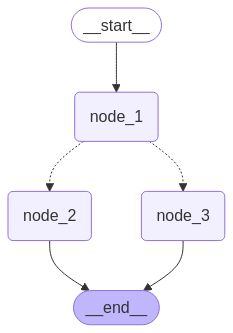

In [44]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'sad'}

In [46]:
graph.invoke(PydanticState(name="Lance",mood="bad"))

ValidationError: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='bad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

# Reducers

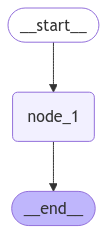

---Node 1---


{'foo': 2}

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"foo" : 1})

Let's look at the state update, return {"foo": state['foo'] + 1}.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.

So, it will just overwrite the value of foo in node_1:

return {"foo": state['foo'] + 1}
If we pass {'foo': 1} as input, the state returned from the graph is {'foo': 2}.